# Create Transit Rich Areas Dataset

A Transit-Rich Area is defined as areas 1/2 mile of:
- An existing, under construction, or fully funded rail station or ferry terminal
- A rail station or ferry terminal included in the PBA 2050 Final Blueprint
- A bus stop with headways of 15 minutes or less during the AM (6:00 - 10:00 AM) and PM (3:00 - 7:00 PM) peak periods in January 2020

In [22]:
import os
import sys
import pandas as pd, geopandas as gp, matplotlib.pyplot as plt, numpy as np
import json
import fiona
import requests
import getpass
from pyproj import CRS
from arcgis.gis import GIS
from arcgis.features import GeoAccessor, GeoSeriesAccessor
from arcgis.features import FeatureLayerCollection

user = getpass.getuser()
sys.dont_write_bytecode = True

sys.path.insert(0, '/Users/{}/Box/DataViz Projects/Utility Code'.format(user))

from utils_io import *

### Read in password from file

**Important:** Do not put passwords or sensitive information into this notebook. Read in from seperate file or add to DataViz creds file. 

In [23]:
def get_file_contents(filename):
    """ Given a filename,
        return the contents of that file
    """
    try:
        with open(filename, 'r') as f:
            # It's assumed our file contains a single line,
            # with our API key
            return f.read().strip()
    except FileNotFoundError:
        print("'%s' file not found" % filename)

In [24]:
pass_txt = '../../../../passwords/arcgis_enterprise_pass.txt'
password = get_file_contents(pass_txt)

In [25]:
gis = GIS("https://arcgis.ad.mtc.ca.gov/portal/", "jcroff", password)

## Pull Existing Transit Stops 2020 Data from Portal and Buffer

In [26]:
# transit_stops = gis.content.get('3faf8401623b48ae8d70f7a71d7365c9')

In [27]:
# transit_stops

In [28]:
# transit_stops_lyr = transit_stops.layers[0]

In [29]:
# transit_stops_lyr.query(out_sr='32610')

In [30]:
#Pull data from arcgis portal
transit_stops_exist = pull_geodata_from_argis('3faf8401623b48ae8d70f7a71d7365c9',client=gis)

In [31]:
transit_stops_exist.crs

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

In [32]:
transit_stops_exist.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 22274 entries, 0 to 22273
Data columns (total 15 columns):
 #   Column      Non-Null Count  Dtype   
---  ------      --------------  -----   
 0   agency_id   22252 non-null  object  
 1   agency_nm   22252 non-null  object  
 2   hdwy_15min  22274 non-null  int64   
 3   hdwy_30min  22274 non-null  int64   
 4   hdwy_class  22274 non-null  object  
 5   loc_type    22274 non-null  object  
 6   major_stop  22274 non-null  int64   
 7   objectid    22274 non-null  int64   
 8   route_ty_t  22252 non-null  object  
 9   route_type  22252 non-null  float64 
 10  stop_code   22274 non-null  object  
 11  stop_desc   22274 non-null  object  
 12  stop_id     22274 non-null  object  
 13  stop_name   22274 non-null  object  
 14  geom        22274 non-null  geometry
dtypes: float64(1), geometry(1), int64(4), object(9)
memory usage: 2.5+ MB


In [33]:
#project to WGS 84 / UTM zone 10N
transit_stops_exist_utmz10 = transit_stops_exist.to_crs('EPSG:32610')

In [34]:
transit_stops_exist_utmz10.crs

<Projected CRS: EPSG:32610>
Name: WGS 84 / UTM zone 10N
Axis Info [cartesian]:
- E[east]: Easting (metre)
- N[north]: Northing (metre)
Area of Use:
- name: World - N hemisphere - 126°W to 120°W - by country
- bounds: (-126.0, 0.0, -120.0, 84.0)
Coordinate Operation:
- name: UTM zone 10N
- method: Transverse Mercator
Datum: World Geodetic System 1984
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

In [35]:
transit_stops_exist_utmz10.head(5)

,agency_id,agency_nm,hdwy_15min,hdwy_30min,hdwy_class,loc_type,major_stop,objectid,route_ty_t,route_type,stop_code,stop_desc,stop_id,stop_name,geom
0,BA,Bay Area Rapid Transit,1,1,15 mins or less,0,1,1,Rail,2.0,12TH,,12TH,12th St. Oakland City Center,POINT (564135.244 4184293.205)
1,BA,Bay Area Rapid Transit,1,1,15 mins or less,0,1,2,Rail,2.0,16TH,,16TH,16th St. Mission,POINT (551112.002 4179906.983)
2,BA,Bay Area Rapid Transit,1,1,15 mins or less,0,1,3,Rail,2.0,19TH,,19TH,19th St. Oakland,POINT (564382.160 4184803.318)
3,BA,Bay Area Rapid Transit,1,1,15 mins or less,0,1,4,Rail,2.0,24TH,,24TH,24th St. Mission,POINT (551257.209 4178510.984)
4,BA,Bay Area Rapid Transit,1,1,15 mins or less,0,1,5,Rail,2.0,ANTC,,ANTC,Antioch,POINT (607084.546 4206005.178)


In [36]:
transit_stops_exist_utmz10.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 22274 entries, 0 to 22273
Data columns (total 15 columns):
 #   Column      Non-Null Count  Dtype   
---  ------      --------------  -----   
 0   agency_id   22252 non-null  object  
 1   agency_nm   22252 non-null  object  
 2   hdwy_15min  22274 non-null  int64   
 3   hdwy_30min  22274 non-null  int64   
 4   hdwy_class  22274 non-null  object  
 5   loc_type    22274 non-null  object  
 6   major_stop  22274 non-null  int64   
 7   objectid    22274 non-null  int64   
 8   route_ty_t  22252 non-null  object  
 9   route_type  22252 non-null  float64 
 10  stop_code   22274 non-null  object  
 11  stop_desc   22274 non-null  object  
 12  stop_id     22274 non-null  object  
 13  stop_name   22274 non-null  object  
 14  geom        22274 non-null  geometry
dtypes: float64(1), geometry(1), int64(4), object(9)
memory usage: 2.5+ MB


In [37]:
transit_stops_exist_utmz10['route_ty_t'].unique()

array(['Rail', 'Bus', 'Tram, Streetcar, Light Rail', 'Cable Tram', None,
       'Ferry'], dtype=object)

In [38]:
#Filter stops to include stops w/ types as well as stops with routes headways of 15 mins or less
transit_stops_exist_utmz10 = transit_stops_exist_utmz10[((transit_stops_exist_utmz10['hdwy_15min'] == 1) & 
                                                         (transit_stops_exist_utmz10['route_ty_t'] == 'Bus')) |
                                                        (transit_stops_exist_utmz10['route_ty_t'].isin(['Rail',  
                                                                                              'Tram, Streetcar, Light Rail',
                                                                                              'Cable Tram',
                                                                                              'Ferry']))].copy()

In [39]:
transit_stops_exist_utmz10.shape

(6546, 15)

In [40]:
transit_stops_exist_utmz10.tail(10)

,agency_id,agency_nm,hdwy_15min,hdwy_30min,hdwy_class,loc_type,major_stop,objectid,route_ty_t,route_type,stop_code,stop_desc,stop_id,stop_name,geom
22034,SA,Sonoma Marin Area Rail Transit,0,0,31 mins or more,0,1,22053,Rail,2.0,7103,The station is located at 3801 Civic Center Dr...,SA:7103,Marin Civic Center Station,POINT (540623.071 4206089.096)
22035,SA,Sonoma Marin Area Rail Transit,0,1,16 to 30 min,0,1,22054,Rail,2.0,7105,,SA:7105,Novato Downtown,POINT (538189.516 4217660.087)
22036,SA,Sonoma Marin Area Rail Transit,0,0,31 mins or more,0,1,22055,Rail,2.0,7104,The station is located at 10 Main Gate Road No...,SA:7104,Novato Hamilton Station,POINT (541768.436 4212170.847)
22037,SA,Sonoma Marin Area Rail Transit,0,1,16 to 30 min,0,1,22056,Rail,2.0,7106,The station is located at 7700 Redwood Blvd No...,SA:7106,Novato San Marin Station,POINT (538032.861 4219288.209)
22038,SA,Sonoma Marin Area Rail Transit,0,0,31 mins or more,0,1,22057,Rail,2.0,7107,The station is located at 220 Lakeville Street...,SA:7107,Petaluma Downtown,POINT (531995.142 4232183.250)
22039,SA,Sonoma Marin Area Rail Transit,0,0,31 mins or more,0,1,22058,Rail,2.0,7110,The station is located at 900 Enterprise Drive...,SA:7110,Rohnert Park,POINT (526109.602 4244412.031)
22040,SA,Sonoma Marin Area Rail Transit,0,0,31 mins or more,0,1,22059,Rail,2.0,7102,The station is located at 680 3rd Street San R...,SA:7102,San Rafael Station,POINT (541912.986 4202804.666)
22041,SA,Sonoma Marin Area Rail Transit,0,0,31 mins or more,0,1,22060,Rail,2.0,7111,The station is located at 7 4th Street Santa R...,SA:7111,Santa Rosa Downtown Station,POINT (524288.139 4254397.256)
22042,SA,Sonoma Marin Area Rail Transit,0,0,31 mins or more,0,1,22061,Rail,2.0,7112,The station is located at 1500 Guernevile Road...,SA:7112,Santa Rosa North Station,POINT (522973.306 4256399.581)
22043,SA,Sonoma Marin Area Rail Transit,0,0,31 mins or more,0,1,22062,Rail,2.0,7113,The station is located at 1130 Airport Blvd Sa...,SA:7113,Sonoma County Airport Station,POINT (518840.980 4262376.343)


In [41]:
#Buffer existing transit stops by 1/2 mile
buffer_distance = .5 * 1609.344
transit_stops_exist_utmz10['geom'] = transit_stops_exist_utmz10.buffer(buffer_distance)

In [42]:
transit_stops_exist_utmz10.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
Int64Index: 6546 entries, 0 to 22043
Data columns (total 15 columns):
 #   Column      Non-Null Count  Dtype   
---  ------      --------------  -----   
 0   agency_id   6546 non-null   object  
 1   agency_nm   6546 non-null   object  
 2   hdwy_15min  6546 non-null   int64   
 3   hdwy_30min  6546 non-null   int64   
 4   hdwy_class  6546 non-null   object  
 5   loc_type    6546 non-null   object  
 6   major_stop  6546 non-null   int64   
 7   objectid    6546 non-null   int64   
 8   route_ty_t  6546 non-null   object  
 9   route_type  6546 non-null   float64 
 10  stop_code   6546 non-null   object  
 11  stop_desc   6546 non-null   object  
 12  stop_id     6546 non-null   object  
 13  stop_name   6546 non-null   object  
 14  geom        6546 non-null   geometry
dtypes: float64(1), geometry(1), int64(4), object(9)
memory usage: 818.2+ KB


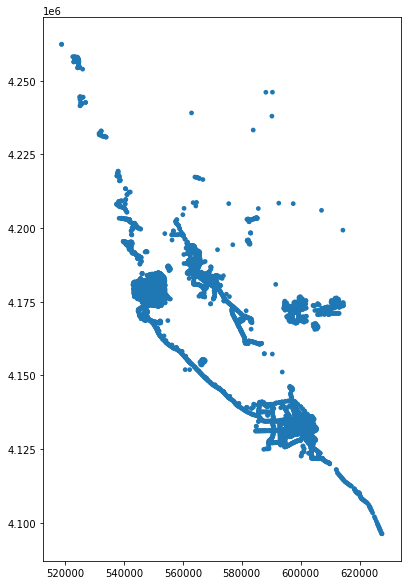

In [43]:
transit_stops_exist_utmz10.plot(figsize=(10,10));

## Pull Planned and Potential Stops from Portal and Buffer

In [44]:
# transit_stop_plan = gis.content.get('18a6239819b048fab9c87bb4d7649560')
# transit_stop_plan

In [45]:
# transit_stop_plan_lyr = transit_stop_plan.layers[0]

In [46]:
# transit_stop_plan_lyr

In [47]:
# transit_stop_plan_lyr_utmz10 = transit_stop_plan_lyr.query(out_sr='32610')

In [48]:
# transit_stop_plan_lyr_utmz10.spatial_reference

In [49]:
#Pull data from arcgis portal
transit_stops_plan = pull_geodata_from_argis('18a6239819b048fab9c87bb4d7649560',client=gis)

In [50]:
transit_stops_plan.crs

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

In [51]:
#Project to WGS84 UTMZ10
transit_stops_plan_utmz10 = transit_stops_plan.to_crs('EPSG:32610')

In [52]:
transit_stops_plan_utmz10.crs

<Projected CRS: EPSG:32610>
Name: WGS 84 / UTM zone 10N
Axis Info [cartesian]:
- E[east]: Easting (metre)
- N[north]: Northing (metre)
Area of Use:
- name: World - N hemisphere - 126°W to 120°W - by country
- bounds: (-126.0, 0.0, -120.0, 84.0)
Coordinate Operation:
- name: UTM zone 10N
- method: Transverse Mercator
Datum: World Geodetic System 1984
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

In [53]:
transit_stops_plan_utmz10.head(5)

,objectid,county,jurisdictn,agency_nm,stop_name,route_ty_t,ppa_id,ppa_name,committd,status,exp_open,geom
0,1,CA013,Brentwood,TBD,Brentwood,Bus,2202,Bus Rapid Transit to Brentwood (formerly BART ...,No,Final Blueprint,2021-2035,POINT (610284.281 4201385.715)
1,2,CA097,Healdsburg,Sonoma-Marin Area Rail Transit,Healdsburg,Rail,2304,SMART to Cloverdale,No,Not Included,Not Included,POINT (511636.968 4273185.826)
2,3,CA097,Cloverdale,Sonoma-Marin Area Rail Transit,Cloverdale,Rail,2304,SMART to Cloverdale,No,Not Included,Not Included,POINT (498953.967 4294420.424)
3,4,CA085,San Jose,Santa Clara Valley Transportation Authority,San Jose Airport,"Tram, Streetcar, Light Rail",2402,San Jose Airport People Mover,No,Not Included,Not Included,POINT (595075.482 4136054.501)
4,5,CA085,Cupertino,Bay Area Rapid Transit,De Anza College,"Tram, Streetcar, Light Rail",2206,Stevens Creek Line (formerly BART to Cupertino),No,Final Blueprint,2036-2050,POINT (585044.618 4131116.515)


In [54]:
transit_stops_plan_utmz10['status'].unique()

array(['Final Blueprint', 'Not Included', 'Draft Blueprint',
       'Under Construction'], dtype=object)

In [55]:
#filter for stops in the Final Blueprint or Under Construction
transit_stops_plan_utmz10 = transit_stops_plan_utmz10[(transit_stops_plan_utmz10['status'].isin(['Final Blueprint',
                                                                                             'Under Construction'])) |
                                                     (transit_stops_plan_utmz10['stop_name'] == 'Irvington')].copy()

In [56]:
transit_stops_plan_utmz10.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
Int64Index: 19 entries, 0 to 91
Data columns (total 12 columns):
 #   Column      Non-Null Count  Dtype   
---  ------      --------------  -----   
 0   objectid    19 non-null     int64   
 1   county      19 non-null     object  
 2   jurisdictn  19 non-null     object  
 3   agency_nm   19 non-null     object  
 4   stop_name   19 non-null     object  
 5   route_ty_t  18 non-null     object  
 6   ppa_id      19 non-null     int64   
 7   ppa_name    19 non-null     object  
 8   committd    19 non-null     object  
 9   status      19 non-null     object  
 10  exp_open    19 non-null     object  
 11  geom        19 non-null     geometry
dtypes: geometry(1), int64(2), object(9)
memory usage: 1.9+ KB


In [57]:
transit_stops_plan_utmz10.head(10)

,objectid,county,jurisdictn,agency_nm,stop_name,route_ty_t,ppa_id,ppa_name,committd,status,exp_open,geom
0,1,CA013,Brentwood,TBD,Brentwood,Bus,2202,Bus Rapid Transit to Brentwood (formerly BART ...,No,Final Blueprint,2021-2035,POINT (610284.281 4201385.715)
4,5,CA085,Cupertino,Bay Area Rapid Transit,De Anza College,"Tram, Streetcar, Light Rail",2206,Stevens Creek Line (formerly BART to Cupertino),No,Final Blueprint,2036-2050,POINT (585044.618 4131116.515)
5,6,CA085,Cupertino,Bay Area Rapid Transit,Wolfe Rd,"Tram, Streetcar, Light Rail",2206,Stevens Creek Line (formerly BART to Cupertino),No,Final Blueprint,2036-2050,POINT (587341.315 4131142.676)
6,7,CA085,San Jose,Bay Area Rapid Transit,Santana Row,"Tram, Streetcar, Light Rail",2206,Stevens Creek Line (formerly BART to Cupertino),No,Final Blueprint,2036-2050,POINT (593029.499 4131247.876)
7,8,CA001,Livermore,Tri-Valley - San Joaquin Valley Regional Rail ...,Greenville,Rail,2308,Valley Link,No,Final Blueprint,2021-2035,POINT (614697.756 4174984.841)
8,9,CA001,Livermore,Tri-Valley - San Joaquin Valley Regional Rail ...,Isabel,Rail,2308,Valley Link,No,Final Blueprint,2021-2035,POINT (605601.479 4173297.636)
9,10,CA075,San Francisco,Caltrain,San Francisco Salesforce Transit Center,Rail,2300,Downtown Extension,No,Final Blueprint,2036-2050,POINT (553062.795 4182548.638)
11,12,CA085,Campbell,Santa Clara Valley Transportation Authority,Hacienda,"Tram, Streetcar, Light Rail",2403,Vasona Light Rail Transit Phase II,No,Final Blueprint,2036-2050,POINT (592560.134 4125234.519)
12,13,CA085,Los Gatos,Santa Clara Valley Transportation Authority,Vasona Junction,"Tram, Streetcar, Light Rail",2403,Vasona Light Rail Transit Phase II,No,Final Blueprint,2036-2050,POINT (591876.008 4124047.071)
13,14,CA085,San Jose,Santa Clara Valley Transportation Authority,San Carlos Infill,"Tram, Streetcar, Light Rail",2403,Vasona Light Rail Transit Phase II,No,Final Blueprint,2036-2050,POINT (597174.874 4131378.169)


In [58]:
#Buffer planned and potential stops by 1/2 mile
buffer_distance = .5 * 1609.344
transit_stops_plan_utmz10['geom'] = transit_stops_plan_utmz10.buffer(buffer_distance)

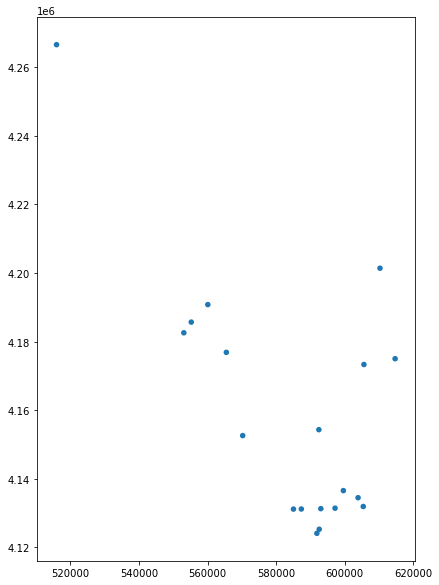

In [59]:
transit_stops_plan_utmz10.plot(figsize=(10,10));

## Pull PBA2050 Transit Project Lines

In [60]:
#pull from portal
transit_lines_plan = pull_geodata_from_argis('c977b5c75587445fb25ba7beea5d2348',client=gis)

In [61]:
transit_lines_plan.crs

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

In [62]:
transit_lines_plan.head(5)

,objectid,proj_name,proj_id,date,edited_by,type,proj_desc,trans_type,final_bp,SHAPE__Length,geom
0,1,Crossing Concept #1,b569ce86-c447-11e9-99c0-003ee1c8de60,2019-8-21,Raleigh McCoy,Line,Crossing 1,None,0,0.226824,"MULTILINESTRING ((-122.09466 37.64571, -122.09..."
1,2,Crossing Concept #2,b56cf8fa-c447-11e9-a898-003ee1c8de60,2019-8-21,Raleigh McCoy,Line,Crossing 2,None,0,0.278014,"MULTILINESTRING ((-122.40540 37.63570, -122.40..."
2,3,Crossing Concept #3,b56cfc46-c447-11e9-b877-003ee1c8de60,2019-8-21,Raleigh McCoy,Line,Crossing 3,None,0,0.303308,"MULTILINESTRING ((-122.46832 37.70637, -122.46..."
3,4,Crossing Concept #4,b56cfc9e-c447-11e9-a5e3-003ee1c8de60,2019-8-21,Raleigh McCoy,Line,Crossing 4,None,0,0.326996,"MULTILINESTRING ((-122.46859 37.70637, -122.46..."
4,5,Crossing Concept #5,b56cfcf8-c447-11e9-8e22-003ee1c8de60,2019-8-21,Raleigh McCoy,Line,Crossing 5,None,0,0.139503,"MULTILINESTRING ((-122.39553 37.78951, -122.39..."


In [63]:
#project to WGS84 UTMZ10
transit_lines_plan_utmz10 = transit_lines_plan.to_crs('EPSG:32610')

In [64]:
transit_lines_plan_utmz10['trans_type'].unique()

array([None, 'Local Bus', 'Group Rapid Transit', 'Commuter Rail',
       'Local Rapid Bus', 'Regional Express Bus', 'Bus Rapid Transit',
       'Light Rail', 'Ferry', 'Bicycle', 'Road',
       'Automated Vehicle Shuttle', 'Maglev Rail'], dtype=object)

In [65]:
#filter for BRT projects
transit_lines_plan_utmz10 = transit_lines_plan_utmz10[(transit_lines_plan_utmz10['final_bp'] == 1) &
                                                    (transit_lines_plan_utmz10['trans_type'] == 'Bus Rapid Transit')].copy()

In [66]:
transit_lines_plan_utmz10.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
Int64Index: 4 entries, 66 to 162
Data columns (total 11 columns):
 #   Column         Non-Null Count  Dtype   
---  ------         --------------  -----   
 0   objectid       4 non-null      int64   
 1   proj_name      4 non-null      object  
 2   proj_id        4 non-null      object  
 3   date           4 non-null      object  
 4   edited_by      4 non-null      object  
 5   type           4 non-null      object  
 6   proj_desc      4 non-null      object  
 7   trans_type     4 non-null      object  
 8   final_bp       4 non-null      int64   
 9   SHAPE__Length  4 non-null      float64 
 10  geom           4 non-null      geometry
dtypes: float64(1), geometry(1), int64(2), object(7)
memory usage: 384.0+ bytes


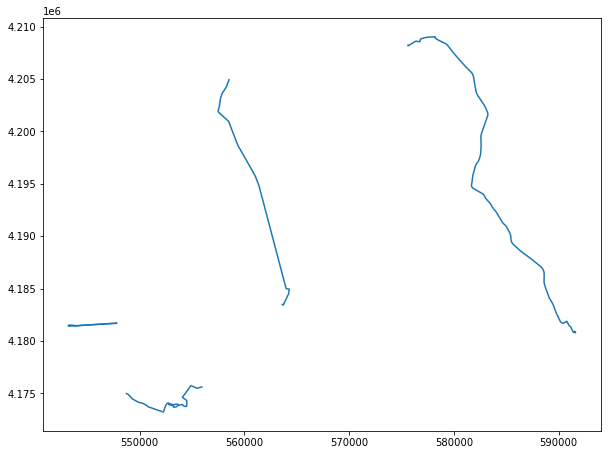

In [67]:
transit_lines_plan_utmz10.plot(figsize=(10,10));

In [68]:
#Buffer BRT transit lines by 1/2 mile
buffer_distance = .5 * 1609.344
transit_lines_plan_utmz10['geom'] = transit_lines_plan_utmz10.buffer(buffer_distance)

In [69]:
transit_lines_plan_utmz10.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
Int64Index: 4 entries, 66 to 162
Data columns (total 11 columns):
 #   Column         Non-Null Count  Dtype   
---  ------         --------------  -----   
 0   objectid       4 non-null      int64   
 1   proj_name      4 non-null      object  
 2   proj_id        4 non-null      object  
 3   date           4 non-null      object  
 4   edited_by      4 non-null      object  
 5   type           4 non-null      object  
 6   proj_desc      4 non-null      object  
 7   trans_type     4 non-null      object  
 8   final_bp       4 non-null      int64   
 9   SHAPE__Length  4 non-null      float64 
 10  geom           4 non-null      geometry
dtypes: float64(1), geometry(1), int64(2), object(7)
memory usage: 384.0+ bytes


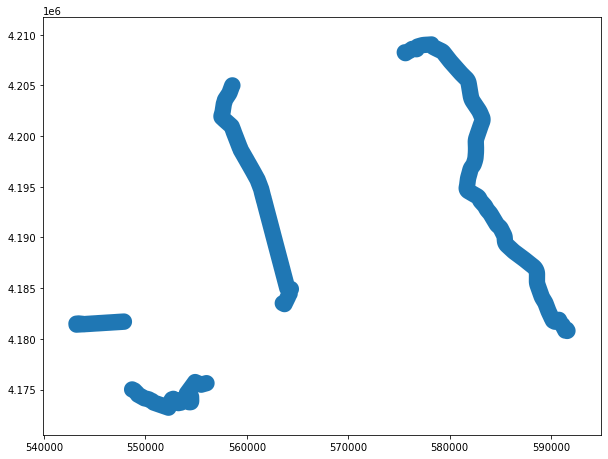

In [70]:
transit_lines_plan_utmz10.plot(figsize=(10,10));

## Append Point Datasets

In [71]:
stops_append = transit_stops_exist_utmz10[['agency_nm',
                                          'route_ty_t',
                                          'stop_name',
                                          'geom']].append(transit_stops_plan_utmz10[['agency_nm',
                                                                                    'route_ty_t',
                                                                                    'stop_name',
                                                                                    'geom']])

In [72]:
stops_append.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
Int64Index: 6565 entries, 0 to 91
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype   
---  ------      --------------  -----   
 0   agency_nm   6565 non-null   object  
 1   route_ty_t  6564 non-null   object  
 2   stop_name   6565 non-null   object  
 3   geom        6565 non-null   geometry
dtypes: geometry(1), object(3)
memory usage: 256.4+ KB


## Append Point and Line Datasets

In [73]:
transit_lines_plan_utmz10.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
Int64Index: 4 entries, 66 to 162
Data columns (total 11 columns):
 #   Column         Non-Null Count  Dtype   
---  ------         --------------  -----   
 0   objectid       4 non-null      int64   
 1   proj_name      4 non-null      object  
 2   proj_id        4 non-null      object  
 3   date           4 non-null      object  
 4   edited_by      4 non-null      object  
 5   type           4 non-null      object  
 6   proj_desc      4 non-null      object  
 7   trans_type     4 non-null      object  
 8   final_bp       4 non-null      int64   
 9   SHAPE__Length  4 non-null      float64 
 10  geom           4 non-null      geometry
dtypes: float64(1), geometry(1), int64(2), object(7)
memory usage: 384.0+ bytes


In [74]:
transit_lines_plan_utmz10.rename(columns={'trans_type':'route_ty_t'},inplace=True)

In [75]:
stops_lines_append = stops_append.append(transit_lines_plan_utmz10[['proj_name',
                                                                   'final_bp',
                                                                   'route_ty_t',
                                                                   'geom']])

In [76]:
stops_lines_append.head(5)

,agency_nm,route_ty_t,stop_name,geom,proj_name,final_bp
0,Bay Area Rapid Transit,Rail,12th St. Oakland City Center,"POLYGON ((564939.916 4184293.205, 564936.041 4...",NaN,NaN
1,Bay Area Rapid Transit,Rail,16th St. Mission,"POLYGON ((551916.674 4179906.983, 551912.799 4...",NaN,NaN
2,Bay Area Rapid Transit,Rail,19th St. Oakland,"POLYGON ((565186.832 4184803.318, 565182.957 4...",NaN,NaN
3,Bay Area Rapid Transit,Rail,24th St. Mission,"POLYGON ((552061.881 4178510.984, 552058.007 4...",NaN,NaN
4,Bay Area Rapid Transit,Rail,Antioch,"POLYGON ((607889.218 4206005.178, 607885.343 4...",NaN,NaN


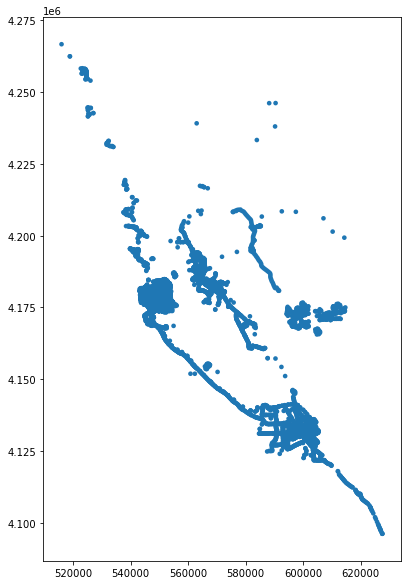

In [77]:
stops_lines_append.plot(figsize=(10,10));

In [78]:
stops_lines_append.crs

<Projected CRS: EPSG:32610>
Name: WGS 84 / UTM zone 10N
Axis Info [cartesian]:
- E[east]: Easting (metre)
- N[north]: Northing (metre)
Area of Use:
- name: World - N hemisphere - 126°W to 120°W - by country
- bounds: (-126.0, 0.0, -120.0, 84.0)
Coordinate Operation:
- name: UTM zone 10N
- method: Transverse Mercator
Datum: World Geodetic System 1984
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

In [79]:
#Unproject 
stops_lines_append_wgs84 = stops_lines_append.to_crs('EPSG:4326')

In [80]:
stops_lines_append_wgs84.crs

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

In [81]:
#Check geometry type
stops_lines_append_wgs84.geom_type.unique()

array(['Polygon'], dtype=object)

In [82]:
#Dissolve features
stops_lines_append_wgs84['tra'] = 1
stops_lines_append_wgs84_diss = stops_lines_append_wgs84[['tra','geom']].dissolve(by='tra',as_index=False)

In [83]:
#Output to geojson for inspection
stops_lines_append_wgs84_diss.to_file('../transit_rich_areas.geojson',driver='GeoJSON')

## Convert to ESRI spatial data frame

In [84]:
stops_lines_append_wgs84_sdf = pd.DataFrame.spatial.from_geodataframe(stops_lines_append_wgs84_diss,
                                                                      column_name='geom')

In [85]:
stops_lines_append_wgs84_sdf.shape

(1, 2)

In [86]:
stops_lines_append_wgs84_sdf.spatial.sr

{'wkid': 4326}

In [87]:
stops_lines_append_wgs84_sdf.head()

,tra,geom
0,1,"{""rings"": [[[-121.56199876686438, 36.997074940..."


In [87]:
# stops_lines_append_wgs84_sdf.spatial.to_featureclass('../transit_rich_areas_v4.shp')

'/Users/jcroff/Documents/GitHub/Spatial-Analysis-Mapping-Projects/Project-Documentation/Plan-Bay-Area-2050-Growth-Framework/transit_rich_areas_v4.shp'

In [88]:
title = 'Transit Rich Areas 2020 v5'
folder = 'Plan Bay Area 2050'
stops_lines_append_wgs84_sdf.spatial.to_featurelayer(title,folder=folder)

<Item title:"Transit Rich Areas 2020 v5" type:Feature Layer Collection owner:jcroff>

In [89]:
trans = gis.content.get('9efb16077fc7471cbee39e3fe43be481')

In [90]:
trans.layers[0].properties

{
  "currentVersion": 10.8,
  "cimVersion": "2.5.0",
  "id": 0,
  "name": "g3bbd3",
  "type": "Feature Layer",
  "parentLayer": null,
  "defaultVisibility": true,
  "minScale": 0,
  "maxScale": 577790,
  "canScaleSymbols": false,
  "geometryType": "esriGeometryPolygon",
  "description": "",
  "copyrightText": "",
  "editFieldsInfo": null,
  "syncCanReturnChanges": true,
  "relationships": [],
  "isDataVersioned": false,
  "isDataArchived": false,
  "isDataBranchVersioned": false,
  "isCoGoEnabled": false,
  "supportsRollbackOnFailureParameter": true,
  "supportsStatistics": true,
  "supportsAdvancedQueries": true,
  "supportsValidateSQL": true,
  "supportsCoordinatesQuantization": true,
  "supportsCalculate": true,
  "supportsASyncCalculate": true,
  "advancedQueryCapabilities": {
    "supportsReturningQueryExtent": true,
    "supportsStatistics": true,
    "supportsDistinct": true,
    "supportsPagination": true,
    "supportsOrderBy": true,
    "supportsQueryWithDistance": true,
    